In [1]:
#Genetic Algorithm to Trade Stocks Based on Indicators (GATSBI) v1.0
import alpaca_trade_api as tradeapi
from alpaca_trade_api import TimeFrame
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random

In [2]:
BASE_URL = 'https://paper-api.alpaca.markets'
ALPACA_API_KEY = 'PKH15E01MGRA54FBEYRI'
ALPACA_SECRET_KEY = '4U5Q9fPaNDGp8Krj2lYG5NOxjYqqftYQWAlzmxwe'

api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
                    base_url=BASE_URL, api_version='v2')

In [3]:
# Fetch Account
account = api.get_account()

# Print Account Details
print(account.id, account.equity, account.status)

4f8900d0-37c9-4f43-8432-726d8bb9d92a 100000 ACTIVE


In [4]:
# Fetch Apple data from last 100 days
SPY_DATA = api.get_bars("SPY", TimeFrame.Day, start = "2022-01-01", adjustment='raw').df

# Preview Data
print(SPY_DATA)

                             open    high     low   close     volume  \
timestamp                                                              
2022-01-03 05:00:00+00:00  476.45  477.85  473.85  477.71   72859933   
2022-01-04 05:00:00+00:00  479.26  479.98  475.58  477.55   72130318   
2022-01-05 05:00:00+00:00  477.25  477.98  468.29  468.38  102090390   
2022-01-06 05:00:00+00:00  468.00  470.82  465.43  467.94   86899217   
2022-01-07 05:00:00+00:00  468.00  469.20  464.65  466.09   84914433   
...                           ...     ...     ...     ...        ...   
2022-07-22 04:00:00+00:00  398.92  400.18  392.75  395.09   71735015   
2022-07-25 04:00:00+00:00  395.72  396.47  393.21  395.57   53336510   
2022-07-26 04:00:00+00:00  393.84  394.06  389.95  390.89   52767480   
2022-07-27 04:00:00+00:00  394.43  402.88  394.05  401.04   81319074   
2022-07-28 04:00:00+00:00  401.84  406.80  398.15  406.07   73873313   

                           trade_count        vwap  
timestamp 

In [5]:
print(SPY_DATA['close'])

timestamp
2022-01-03 05:00:00+00:00    477.71
2022-01-04 05:00:00+00:00    477.55
2022-01-05 05:00:00+00:00    468.38
2022-01-06 05:00:00+00:00    467.94
2022-01-07 05:00:00+00:00    466.09
                              ...  
2022-07-22 04:00:00+00:00    395.09
2022-07-25 04:00:00+00:00    395.57
2022-07-26 04:00:00+00:00    390.89
2022-07-27 04:00:00+00:00    401.04
2022-07-28 04:00:00+00:00    406.07
Name: close, Length: 143, dtype: float64


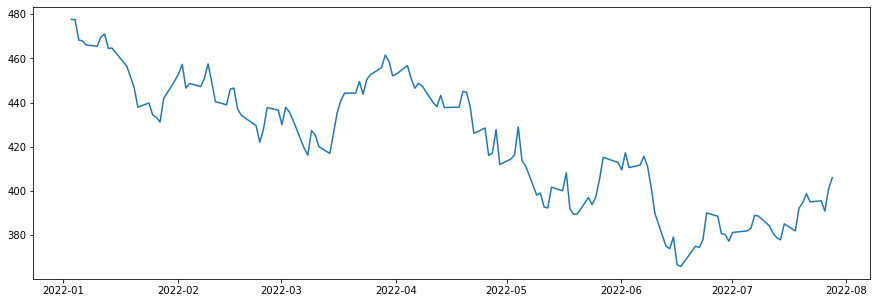

In [6]:
plt.figure(figsize=(15,5))
plt.plot(SPY_DATA['close'])

In [7]:
class Agent():
    def __init__(self, cash):
        self.cash = cash
        self.init_cash = cash
        self.stock = 1
        self.g = []
        for i in range(2):
            self.g.append(0)
        self.date_history = []
        self.trans_history = []

    def reset(self):
        self.cash = self.init_cash
        self.stock = 0
        self.position = "long"
        self.date_history = []
        self.trans_history = []
    
    def randomize(self):
        for i in range(2):
            self.g[i] = random.randint(2,30)

    def evaluate(self, data):
        ema1_df = data.ewm(span=self.g[0], adjust=False).mean()
        ema2_df = data.ewm(span=self.g[1], adjust=False).mean()
        ema1 = ema1_df.tolist()
        ema2 = ema2_df.tolist()
        #print(ema1[-1])
        #print(ema2[-1])
        self.position = "long"
        if ema1[-1] > ema2[-1]:
            self.position = "long"
        elif ema1[-1] < ema2[-1]:
            self.position = "short"
        else:
            if self.position == "long":
                self.position = "short"
            else:
                self.position = "long"
            
        #print(self.position)
        
    def execute(self, price, date):
        #print(self.stock)
        if self.position == "long":
            count = 0
            while self.cash >= price:
                count = count + 1
                self.stock = self.stock + 1
                self.cash = self.cash - price
                #print('buy')
            self.date_history.append(date)
            self.trans_history.append('buy')
            return "Bought " + str(count) + " stocks."
        elif self.position == "short":
            count = 0
            while self.stock > 0:
                count = count + 1
                self.stock = self.stock - 1
                self.cash = self.cash + price
                #print('sell')
            self.date_history.append(date)
            self.trans_history.append('sell')
            return "Sold " + str(count) + " stocks."
    def total_assets(self, price):
        stock_value = self.stock * price
        return stock_value + self.cash
    

In [8]:
class Population:
    
    def __init__(self, n, cash, m):
        self.n = n
        self.cash = cash
        self.m = m
        self.pop = []
        for i in range(self.n):
            self.pop.append(Agent(self.cash))
        for a in self.pop:
            a.randomize()
            
    def evaluate(self, data):
        for agent in self.pop:
            agent.evaluate(data)
    
    def execute(self, price, day):
        for agent in self.pop:
            agent.execute(price, day)
    
    def total_assets_all(self, price):
        tot = 0.0
        for a in self.pop:
            tot = tot + a.total_assets(price)
        return tot
    
    def best_agent(self, price):
        maximum = 0
        index = 0
        for i in range(len(self.pop)):
            if (self.pop[i].total_assets(price)>maximum):
                index = i
                maximum = self.pop[i].total_assets(price)
        return self.pop[index]
    
    def average_assets(self, price):
        return self.total_assets_all(price)/self.n
    
    def select(self, price):
        threshold = random.uniform(0, self.total_assets_all(price))
        total = 0
        for j in range(len(self.pop)):
            total = total+self.pop[j].total_assets(price)
            if total >= threshold:
                return self.pop[j]
    
    def generate_child(self, parent1, parent2):
        child = Agent(self.cash)
        for i in range(len(parent1.g)):
            if random.uniform(0,1) > 0.5:
                child.g[i] = parent1.g[i]
            else:
                child.g[i] = parent2.g[i]
                
            if random.uniform(0,1) <= self.m:
                child.g[i] = random.randint(2,30)
        return child
    
    def next_generation(self, price):
        best_agent = self.best_agent(price)
        best_agent.reset()
        next_gen = []
        next_gen.append(best_agent)
        for i in range(self.n-1):
            parent1 = self.select(price)
            parent2 = self.select(price)
            next_gen.append(self.generate_child(parent1, parent2))
        self.pop = next_gen
    

In [9]:
def get_data(ticker, date, interval):
    ticker = ticker
    start_date_obj = datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.timedelta(days=interval)
    start_date = datetime.datetime.strftime(start_date_obj, '%Y-%m-%d')
    data = api.get_bars(ticker, TimeFrame.Day, start = start_date , end = date, adjustment='raw').df['close']
    return data
    

In [10]:
def run_ga(ticker, start_date, end_date, n, cash, m, generations):    
    population = Population(n, cash, m)
    best_performances = []
    avg_performances = []
    date_obj = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    price_list = api.get_bars(ticker, TimeFrame.Day, start = start_date , end = end_date, adjustment='raw').df['close'].tolist()
    for gen in range(generations):
        date = datetime.datetime.strftime(date_obj, '%Y-%m-%d')
        data = get_data(ticker, date, 30)
        if gen != 0:
            population.next_generation(data.tolist()[-1])
        print('***Started Gen ' + str(gen) + '***')
        print(len(price_list))
        for i in range(len(price_list)-1):
            population.evaluate(data)
            population.execute(price_list[i], date)
        best_agent = population.best_agent(price_list[-1])
        best_performance = best_agent.total_assets(price_list[-1])
        best_performances.append(best_performance)
        avg_assets = population.average_assets(price_list[-1])
        avg_performances.append(avg_assets)
        print('***Average Performance: ' + str(avg_assets) + ' USD***')
        print('***Best Performance: ' + str(best_performance) + ' USD***')
        
    return population

In [11]:
test_population = run_ga('SPY', '2022-01-01', '2022-07-20', 1000, 500, 0.02, 100)

***Started Gen 0***
137
***Average Performance: 897.5899599999879 USD***
***Best Performance: 977.71 USD***
***Started Gen 1***
137
***Average Performance: 895.7852099999878 USD***
***Best Performance: 977.71 USD***
***Started Gen 2***
137
***Average Performance: 896.1169699999878 USD***
***Best Performance: 977.71 USD***
***Started Gen 3***
137
***Average Performance: 899.6004499999879 USD***
***Best Performance: 977.71 USD***
***Started Gen 4***
137
***Average Performance: 896.2828499999879 USD***
***Best Performance: 977.71 USD***
***Started Gen 5***
137


KeyboardInterrupt: 

In [ ]:
print(test_population.best_agent(398).g)

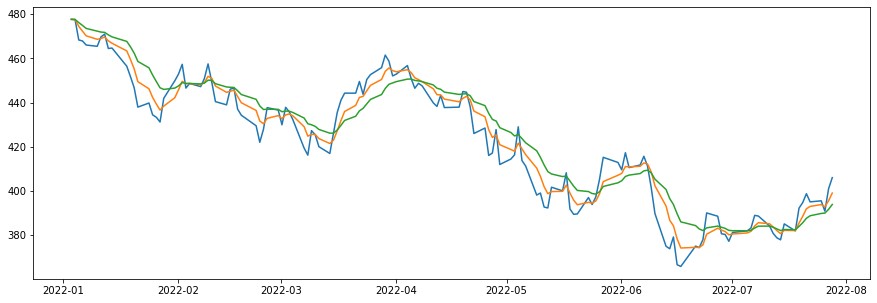

In [12]:
SPY_DATA = api.get_bars("SPY", TimeFrame.Day, start = "2022-01-01", adjustment='raw').df
ema1 = SPY_DATA.ewm(span=5, adjust=False).mean()
ema2 = SPY_DATA.ewm(span=12, adjust=False).mean()
plt.figure(figsize=(15,5))

plt.plot(SPY_DATA['close'])
plt.plot(ema1['close'])
plt.plot(ema2['close'])

In [ ]:
print(test_population.best_agent(398).date_history)

In [ ]:
population = Population(100,500, 0.02)
price_list = api.get_bars("SPY", TimeFrame.Day, start = "2022-01-01" , end = "2022-07-15", adjustment='raw').df['close'].tolist()
data = get_data("SPY", "2022-07-15", 30)
population.evaluate(data)
population.execute(price_list[15], '2022-01-15')